# Figure 2B: correlation of interferon score with proportion.

In [1]:
import sys
import seaborn as sb
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import argparse
import gc
import anndata
import random
import scipy.stats as stats
from decimal import Decimal
import patsy
import math

%matplotlib inline

In [2]:
%matplotlib inline

##################
# Configure file #
##################
sc.settings.verbosity = 2
sc.settings.autoshow = False

##logging.basicConfig(filename="CLUESImmVar_processed.V4.1.log", level=logging.ERROR)
sc.settings.set_figure_params(dpi=100, dpi_save=600, format='png')

plt.rcParams["image.aspect"] = "equal"
##%matplotlib inline

In [3]:
version = "V6.1"

figdir = "./figures."+version+"/"
sc.settings.figdir = figdir

as a proportion of cell type
Cluster type:cM
Beta=1.237837265209619, pvalue=1.1069749801736797e-14
Cluster type:ncM
Beta=0.12481099018470868, pvalue=0.002041367512885798
Cluster type:cDC
Beta=-0.03690267493571106, pvalue=8.47059154665652e-05
Cluster type:pDC
Beta=-0.022996066608325687, pvalue=3.2218876753384006e-07
Cluster type:Th
Beta=-1.32937237234036, pvalue=3.091283904696777e-18
Cluster type:Tc
Beta=0.08768184754286536, pvalue=0.47866009126373144
Cluster type:Th
Beta=-1.32937237234036, pvalue=3.091283904696777e-18
Cluster type:NK
Beta=-0.1579693671966805, pvalue=0.01477477509902297
Cluster type:ProlifT
Beta=0.05351822029588083, pvalue=5.1633310203161424e-12
Cluster type:B
Beta=0.07987827572701356, pvalue=0.514060410562494
Cluster type:MK
Beta=0.007461564013764407, pvalue=0.006361294005270885
Cluster type:Progen
Beta=-0.0012694435159050408, pvalue=0.1941469679233046


/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


as a proportion of cell group
Cluster type:lymph
Beta=-1.263375234781435, pvalue=8.592562283795647e-13
Cluster type:myeloid
Beta=1.2998143232861472, pvalue=2.2664302154567557e-13
Cluster type:progen
Beta=-0.0010402515776513025, pvalue=0.2807197367200041
Cluster type:mono
Beta=1.3603925218116462, pvalue=1.0039778600356041e-14
Cluster type:dc
Beta=-0.060578198525498866, pvalue=1.3070348275645728e-07
Cluster type:mk
Beta=0.0075619092117383685, pvalue=0.006334168749908253


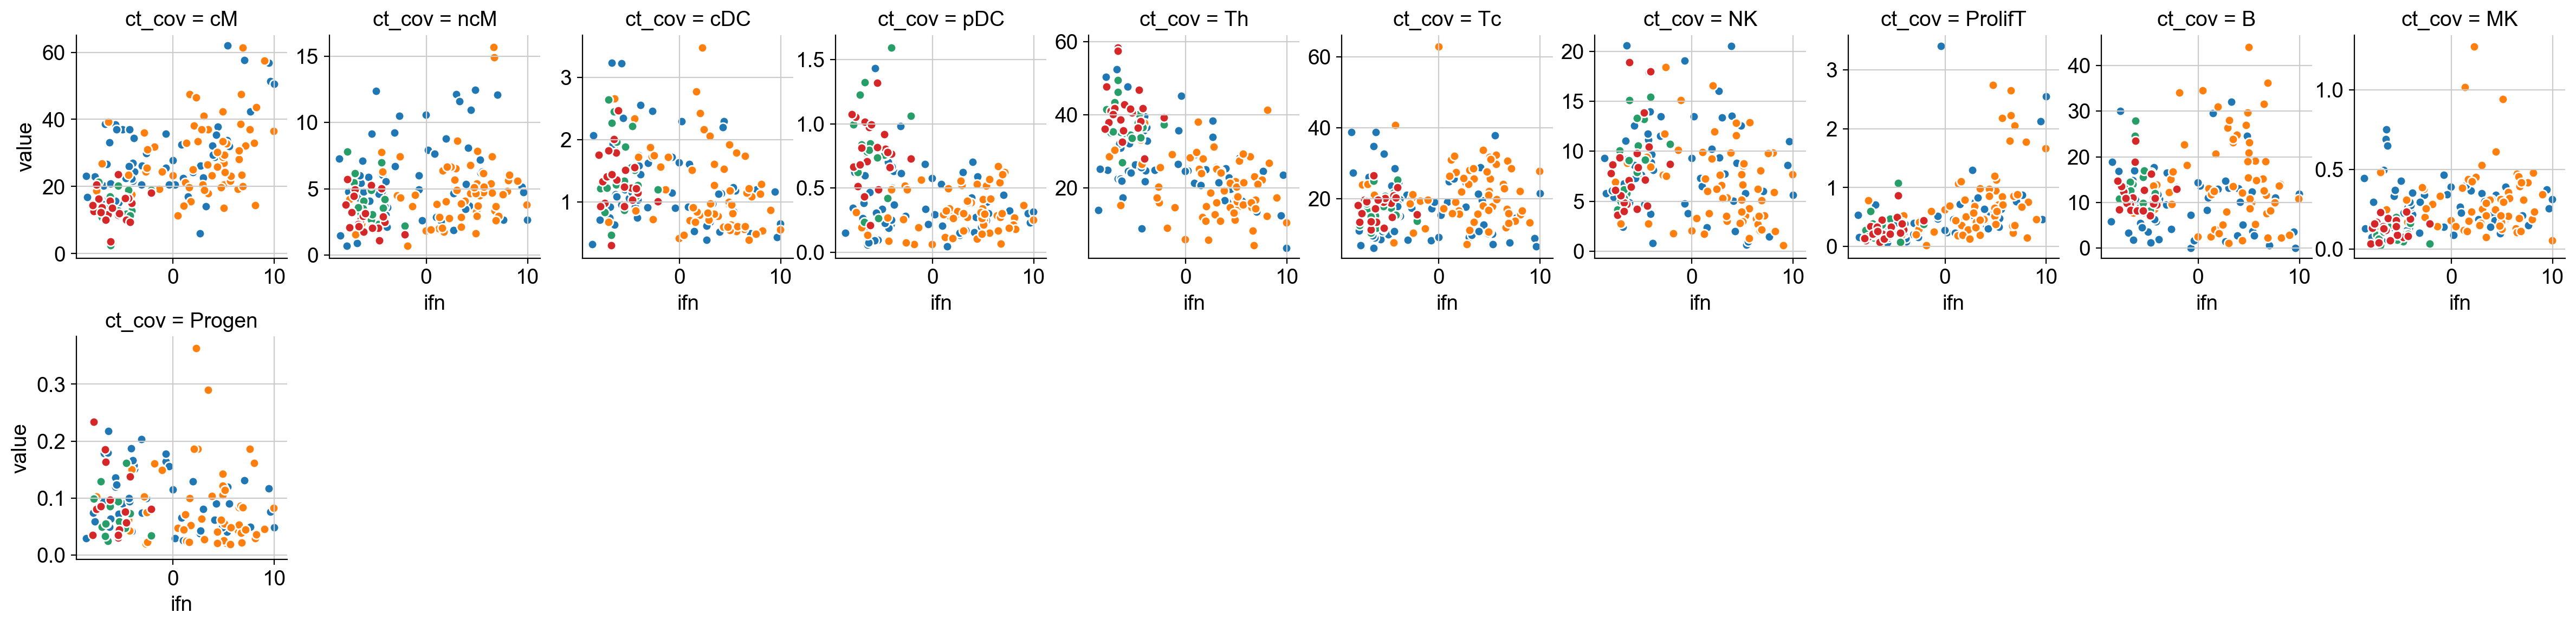

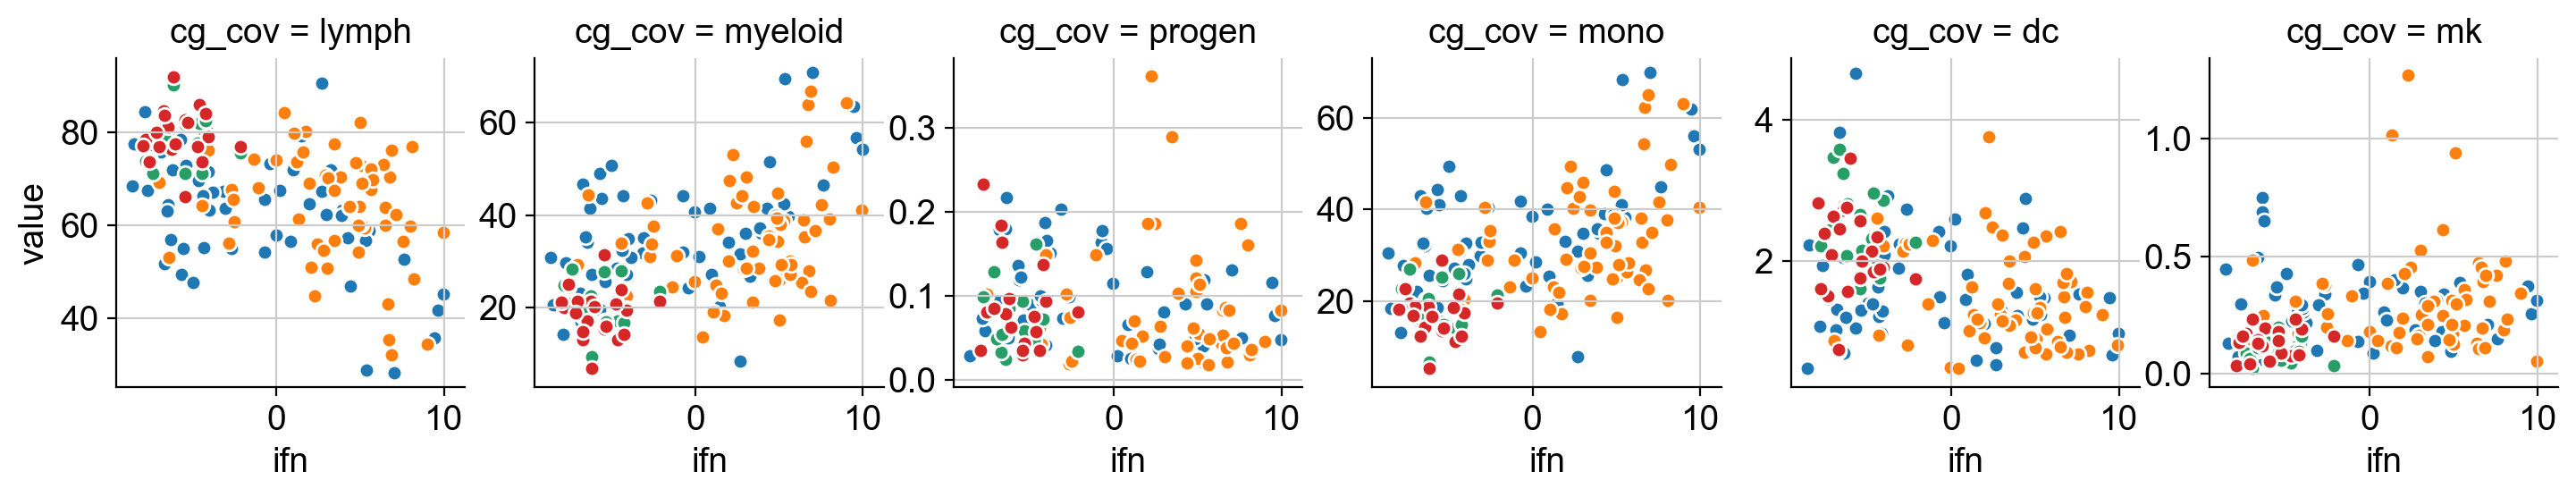

In [4]:
joined_pivot = pd.read_csv("CLUESImmVar_processed_joined_pivot_ct_perc."+version+".txt",index_col=False)
joined_pivot_cg = pd.read_csv("CLUESImmVar_processed_joined_pivot_cg_perc."+version+".txt",index_col=False)
joined_pivot_cg["myeloid"] = joined_pivot_cg.mono+joined_pivot_cg.dc

ifn = pd.read_table("../meta/ifn_sig.V2.txt", sep=" ", index_col=False)
ifn.name = ifn.name.apply(lambda x: x.split('_')[0])
joined_pivot_ifn = ifn.join(joined_pivot.set_index("ind_cov"), on="name")
joined_pivot_cg_ifn = ifn.join(joined_pivot_cg.set_index("ind_cov"), on="name")

cell_types = ["cM", "ncM", "cDC", "pDC", "Th","Tc","Th","NK","ProlifT","B","MK","Progen"];
cg_types = ['lymph', 'myeloid', 'progen', 'mono', 'dc','mk']

index = ["name","ifn","disease_cov","disease_pop_site_cov","batch_cov"];
joined_ifn = pd.melt(joined_pivot_ifn, id_vars=index, value_vars=cell_types, var_name="ct_cov")
joined_cg_ifn = pd.melt(joined_pivot_cg_ifn, id_vars=index, value_vars=cg_types, var_name="cg_cov")

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct in cell_types :
    ##ct = ct_percs.leiden.cat.categories[ct_i]
    ct_perc = joined_pivot_ifn[ct]
    ifn = joined_pivot_ifn.ifn
    ifn = sm.add_constant(ifn)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), ifn.astype(float),missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))
    
g = sb.FacetGrid(joined_ifn, col="ct_cov",  hue="disease_pop_site_cov", aspect=0.8, height=3, sharex=False, sharey=False, palette=sc.pl.palettes.vega_20_scanpy, col_wrap=10)
g = g.map(plt.scatter, "ifn", "value", edgecolor="w")
g.fig.subplots_adjust(wspace=0.2)
g.savefig(figdir+"/ifn_ct_cov.png")

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell group')
for cg in cg_types :
    ##ct = ct_percs.leiden.cat.categories[ct_i]
    cg_perc = joined_pivot_cg_ifn[cg]
    ifn = joined_pivot_cg_ifn.ifn
    ifn = sm.add_constant(ifn)
    print('Cluster type:'+ cg)
    est=sm.OLS(cg_perc.astype(float), ifn.astype(float),missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))
    
g = sb.FacetGrid(joined_cg_ifn, col="cg_cov",  hue="disease_pop_site_cov", aspect=0.8, height=3, sharex=False, sharey=False, palette=sc.pl.palettes.vega_20_scanpy, col_wrap=10)
g = g.map(plt.scatter, "ifn", "value", edgecolor="w")

g.fig.subplots_adjust(wspace=0.2)
g.savefig(figdir+"/ifn_cg_cov.png",height=2)